# Import

In [1]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 20
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import  OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree, export_text, export_graphviz
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import plot_importance as plot_importance_xgb
from lightgbm import plot_importance as plot_importance_lgbm
from catboost import Pool, CatBoostClassifier
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.plotting import plot_decision_regions

from sklearn.ensemble import ExtraTreesClassifier

# Model selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn import metrics
# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Evaluation metrics
from sklearn import metrics
# for classification
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, precision_score, recall_score, f1_score)

from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
# import shap 

In [2]:
# 스케일 조정
def scale(scaler, X_train, X_test):
    scaler_fit = scaler.fit(X_train)
    X_train_scaling = pd.DataFrame(scaler_fit.transform(X_train), 
                                   index=X_train.index, columns=X_train.columns)
    X_test_scaling = pd.DataFrame(scaler_fit.transform(X_test), 
                                  index=X_test.index, columns=X_test.columns)
    
    return X_train_scaling, X_test_scaling


# UnderSampling
def undersampling(X_train, Y_train, method='OneSidedSelection', strategy='auto', random_state=123):
    print('Ratio of Origin Y_train: ', Y_train.value_counts())
    if method == 'RandomUnderSampler':
        sampler = RandomUnderSampler(sampling_strategy=strategy, random_state=random_state)
    elif method == 'TomekLinks':
        sampler = TomekLinks(sampling_strategy=strategy)
    elif method == 'CondensedNearestNeighbour':
        sampler = CondensedNearestNeighbour(sampling_strategy=strategy, random_state=random_state)
    elif method == 'OneSidedSelection':
        sampler = OneSidedSelection(sampling_strategy=strategy, random_state=random_state)
        
    # 축소
    X_train, Y_train = sampler.fit_resample(X_train, Y_train)
    print('Ratio of Sapling Y_train: ', Y_train.value_counts())
    
    return sampler, X_train, Y_train

In [3]:
# Confusion Matrix 함수화
def evaluation_class_ConfusionMatrix(Y_true, Y_pred):
    conf_mat = confusion_matrix(Y_true>=0.5, Y_pred)
    conf_mat = pd.DataFrame(conf_mat, 
                            index=['True: 0', 'True: 1'], 
                            columns=['Pred: 0', 'Pred: 1'])
    
    return conf_mat


# Classification Report 함수화
def evaluation_class_ClassificationReport(Y_true, Y_pred):
    print(classification_report(Y_true, Y_pred, 
                                target_names=['class 0', 'class 1']))


# ROC Curve & AUC 함수화
def evaluation_class_ROCAUC(Y_true, P_pred, figsize=(10,5)):
    fpr, tpr, thresholds = roc_curve(Y_true, P_pred)
    cm = evaluation_class_ConfusionMatrix(Y_true, P_pred>=0.5)
    recall = cm.iloc[1,1] / cm.sum(axis=1).values[1]
    fallout = cm.iloc[0,1] / cm.sum(axis=1).values[0]
    
    plt.figure(figsize=figsize)
    plt.plot(fpr, tpr, label='Logistic Regression')
    plt.plot([0, 1], [0, 1],'r--')
    plt.plot([fallout], [recall], 'ro', ms=10)
    plt.title('AUC: ' + str(auc(fpr, tpr)), fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()


# Precision & Recall Curve 함수화
def evaluation_class_PrecisionRecall(Y_true, P_pred, figsize=(10,5)):
    pre, rec, thresholds = precision_recall_curve(Y_true, P_pred)
    
    plt.figure(figsize=figsize)
    plt.plot(thresholds, pre[:-1], label='Precision')
    plt.plot(thresholds, rec[1:], label='Recall')
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='best', fontsize=12)
    plt.grid()
    plt.show()
    
def evaluation_class_AccuracyAUC(Y_real, Y_pred_prob):
    # 0.5 기준으로 확률을 이진 레이블로 변환하여 accuracy 계산
    Y_pred_label = np.where(Y_pred_prob >= 0.5, 1, 0)
    accuracy = accuracy_score(Y_real, Y_pred_label)
    roc_auc = roc_auc_score(Y_real, Y_pred_prob)  # 확률 값을 그대로 사용
    result = pd.DataFrame({'Accuracy': [accuracy], 'ROC_AUC': [roc_auc]})
    return result

def evaluation_class_AccuracyAUC_trte(Y_real_tr, Y_pred_tr_prob, Y_real_te, Y_pred_te_prob):
    Score_tr = evaluation_class_AccuracyAUC(Y_real_tr, Y_pred_tr_prob)
    Score_te = evaluation_class_AccuracyAUC(Y_real_te, Y_pred_te_prob)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte

# Data Load

In [19]:
train = pd.read_csv('./train.csv').drop(columns=['ID'])
test = pd.read_csv('./test.csv').drop(columns=['ID'])

In [20]:
display(train, test)

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,3.00,NaN,0
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,2.00,NaN,0
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN,0
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,3.00,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256346,TRYBLT,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,5.00,NaN,0
256347,TRYBLT,만38-39세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,3.00,NaN,1
256348,TRVNRY,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,3.00,NaN,0
256349,TRZKPL,만38-39세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,0.00,0.00,NaN,NaN,0.00,NaN,0.00,1.00,NaN,1


,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,신선 배아 사용 여부,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일
0,TRYBLT,만35-37세,NaN,IVF,IVF,1,기록되지 않은 시행,0.00,NaN,0.00,...,1.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN
1,TRDQAZ,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.00,NaN,0.00,...,1.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN
2,TRCMWS,만40-42세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,1.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,3.00,NaN
3,TRJXFG,만40-42세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,1.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,2.00,NaN
4,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,1.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,5.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90062,TRDQAZ,만18-34세,NaN,IVF,ICSI:ICSI,1,기록되지 않은 시행,0.00,NaN,1.00,...,1.00,0.00,0.00,NaN,NaN,0.00,NaN,0.00,NaN,NaN
90063,TRYBLT,만43-44세,NaN,IVF,Unknown,0,알 수 없음,0.00,NaN,0.00,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,0.00,0.00
90064,TRVNRY,만18-34세,NaN,IVF,IVF,0,알 수 없음,1.00,NaN,0.00,...,1.00,0.00,0.00,NaN,NaN,NaN,NaN,0.00,5.00,NaN
90065,TRCMWS,만43-44세,NaN,IVF,Unknown,0,알 수 없음,0.00,NaN,0.00,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,4.00,0.00


## Train, Test data 가공 (파생 변수 처리) 

In [21]:
# 나이 변수 가공 및 추가
age_mapping = {
    "만18-34세": 26,
    "만35-37세": 36,
    "만38-39세": 38.5,
    "만40-42세": 41,
    "만43-44세": 43.5,
    "만45-50세": 47.5
}

train["나이_평균"] = train["시술 당시 나이"].map(age_mapping)
test["나이_평균"] = test["시술 당시 나이"].map(age_mapping)


## 연속형 변수로 다루기 위한 나이 제곱값 추가 (비선형 관계 반영)
## 35세 이상 여부 변수가 추가 (고위험군 분류)
train["나이_제곱"] = train["나이_평균"]**2
train["나이_35세 이상"] = (train["나이_평균"]>=35).astype(int)

test["나이_제곱"] = test["나이_평균"]**2
test["나이_35세 이상"] = (test["나이_평균"]>=35).astype(int)

## 중복 정보 제거
train = train.drop(columns="나이_평균")
test = test.drop(columns="나이_평균")


# 배아 관련 변수 가공
train["배아_이식_비율"] = train["이식된 배아 수"] / (train["총 생성 배아 수"] + 1)  # 0 나누기 방지
train["난자_수정_성공률"] = train["총 생성 배아 수"] / (train["혼합된 난자 수"] + 1)

test["배아_이식_비율"] = test["이식된 배아 수"] / (test["총 생성 배아 수"] + 1) 
test["난자_수정_성공률"] = test["총 생성 배아 수"] / (test["혼합된 난자 수"] + 1)

#과거 시술 경험 변수 추가
age_mapping = {
    "0회": 0,
    "1회": 1,
    "2회": 2,
    "3회": 3,
    "4회": 4,
    "5회": 5,
    "6회": 6,
    "6회 이상": 7
}

cols_to_map = ["IVF 시술 횟수", "IVF 임신 횟수", "IVF 출산 횟수", 
               "DI 시술 횟수", "DI 임신 횟수", "DI 출산 횟수"]

train[cols_to_map] = train[cols_to_map].replace(age_mapping)
test[cols_to_map] = test[cols_to_map].replace(age_mapping)


train["이전_IVF_성공률"] = train["IVF 출산 횟수"] / (train["IVF 시술 횟수"] + 1)
train["이전_IVF_임신률"] = train["IVF 임신 횟수"] / (train["IVF 시술 횟수"] + 1)

train["이전_DI_성공률"] = train["DI 출산 횟수"] / (train["DI 시술 횟수"] + 1)
train["이전_DI_임신률"] = train["DI 임신 횟수"] / (train["DI 시술 횟수"] + 1)


test["이전_IVF_성공률"] = test["IVF 출산 횟수"] / (test["IVF 시술 횟수"] + 1)
test["이전_IVF_임신률"] = test["IVF 임신 횟수"] / (test["IVF 시술 횟수"] + 1)

test["이전_DI_성공률"] = test["DI 출산 횟수"] / (test["DI 시술 횟수"] + 1)
test["이전_DI_임신률"] = test["DI 임신 횟수"] / (test["DI 시술 횟수"] + 1)


# 정자,난자 기증여부 변수 추가
train["기증_여부"] = ((train["정자 출처"] == "기증 제공") | (train["난자 출처"] == "기증 제공")).astype(int)
test["기증_여부"] = ((test["정자 출처"] == "기증 제공") | (test["난자 출처"] == "기증 제공")).astype(int)


#주요 난임 원인 변수 생성
train["주요_난임_요인"] = ((train["불임 원인 - 배란 장애"] == 1) | 
                   (train["불임 원인 - 남성 요인"] == 1) | 
                   (train["불임 원인 - 난관 질환"] == 1)).astype(int)

test["주요_난임_요인"] = ((test["불임 원인 - 배란 장애"] == 1) | 
                   (test["불임 원인 - 남성 요인"] == 1) | 
                   (test["불임 원인 - 난관 질환"] == 1)).astype(int)


# 데이터 저장
train.to_csv("./processed_train_with_features.csv", index=False)
test.to_csv("./processed_test_with_features.csv", index=False)

 ## data load

In [22]:
train = pd.read_csv('./processed_train_with_features.csv')
test = pd.read_csv('./processed_test_with_features.csv')

In [23]:
display(train,test)

,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,나이_제곱,나이_35세 이상,배아_이식_비율,난자_수정_성공률,이전_IVF_성공률,이전_IVF_임신률,이전_DI_성공률,이전_DI_임신률,기증_여부,주요_난임_요인
0,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,676.00,0,0.40,0.67,0.00,0.00,0.00,0.00,0,1
1,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.00,NaN,0.00,...,"2,256.25",1,0.00,0.00,0.00,0.00,0.00,0.00,0,0
2,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.00,NaN,0.00,...,676.00,0,0.33,0.62,0.00,0.00,0.00,0.00,0,1
3,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,296.00",1,0.00,0.00,0.00,0.00,0.00,0.00,0,1
4,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,676.00,0,0.29,0.86,0.00,0.00,0.00,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256346,TRYBLT,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,676.00,0,0.33,0.56,0.00,0.00,0.00,0.00,0,0
256347,TRYBLT,만38-39세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,482.25",1,0.50,0.75,0.40,0.40,0.00,0.00,0,1
256348,TRVNRY,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,296.00",1,0.29,0.86,0.00,0.00,0.00,0.00,0,1
256349,TRZKPL,만38-39세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,482.25",1,0.67,0.67,0.00,0.00,0.00,0.00,0,0


,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,착상 전 유전 진단 사용 여부,...,나이_제곱,나이_35세 이상,배아_이식_비율,난자_수정_성공률,이전_IVF_성공률,이전_IVF_임신률,이전_DI_성공률,이전_DI_임신률,기증_여부,주요_난임_요인
0,TRYBLT,만35-37세,NaN,IVF,IVF,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,296.00",1,0.00,0.78,0.00,0.00,0.00,0.00,0,0
1,TRDQAZ,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.00,NaN,0.00,...,676.00,0,0.00,0.00,0.00,0.00,0.00,0.00,1,1
2,TRCMWS,만40-42세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,681.00",1,0.50,0.50,0.00,0.00,0.00,0.00,0,0
3,TRJXFG,만40-42세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,681.00",1,0.67,0.67,0.00,0.00,0.00,0.00,0,0
4,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.00,NaN,0.00,...,"1,296.00",1,0.18,0.91,0.00,0.00,0.00,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90062,TRDQAZ,만18-34세,NaN,IVF,ICSI:ICSI,1,기록되지 않은 시행,0.00,NaN,1.00,...,676.00,0,0.00,0.91,0.00,0.00,0.00,0.00,0,0
90063,TRYBLT,만43-44세,NaN,IVF,Unknown,0,알 수 없음,0.00,NaN,0.00,...,"1,892.25",1,2.00,0.00,0.00,0.00,0.00,0.00,1,0
90064,TRVNRY,만18-34세,NaN,IVF,IVF,0,알 수 없음,1.00,NaN,0.00,...,676.00,0,0.06,0.62,0.00,0.00,0.00,0.00,1,1
90065,TRCMWS,만43-44세,NaN,IVF,Unknown,0,알 수 없음,0.00,NaN,0.00,...,"1,892.25",1,2.00,0.00,0.00,0.00,0.00,0.12,1,0


# Data Pre-processing

In [24]:
# Train data X,Y Split (Test는 y 컬럼 없음. 예측 후 제출해야 성능알 수 있음 ^_^)
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

In [25]:
categorical_columns = [
    "시술 시기 코드",
    "시술 당시 나이",
    "시술 유형",
    "특정 시술 유형",
    "배란 자극 여부",
    "배란 유도 유형",
    "단일 배아 이식 여부",
    "착상 전 유전 검사 사용 여부",
    "착상 전 유전 진단 사용 여부",
    "남성 주 불임 원인",
    "남성 부 불임 원인",
    "여성 주 불임 원인",
    "여성 부 불임 원인",
    "부부 주 불임 원인",
    "부부 부 불임 원인",
    "불명확 불임 원인",
    "불임 원인 - 난관 질환",
    "불임 원인 - 남성 요인",
    "불임 원인 - 배란 장애",
    "불임 원인 - 여성 요인",
    "불임 원인 - 자궁경부 문제",
    "불임 원인 - 자궁내막증",
    "불임 원인 - 정자 농도",
    "불임 원인 - 정자 면역학적 요인",
    "불임 원인 - 정자 운동성",
    "불임 원인 - 정자 형태",
    "배아 생성 주요 이유",
    "총 시술 횟수",
    "클리닉 내 총 시술 횟수",
    "IVF 시술 횟수",
    "DI 시술 횟수",
    "총 임신 횟수",
    "IVF 임신 횟수",
    "DI 임신 횟수",
    "총 출산 횟수",
    "IVF 출산 횟수",
    "DI 출산 횟수",
    "난자 출처",
    "정자 출처",
    "난자 기증자 나이",
    "정자 기증자 나이",
    "동결 배아 사용 여부",
    "신선 배아 사용 여부",
    "기증 배아 사용 여부",
    "대리모 여부",
    "PGD 시술 여부",
    "PGS 시술 여부"
]

In [26]:
# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

In [27]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [28]:
numeric_columns = [
    "임신 시도 또는 마지막 임신 경과 연수",
    "총 생성 배아 수",
    "미세주입된 난자 수",
    "미세주입에서 생성된 배아 수",
    "이식된 배아 수",
    "미세주입 배아 이식 수",
    "저장된 배아 수",
    "미세주입 후 저장된 배아 수",
    "해동된 배아 수",
    "해동 난자 수",
    "수집된 신선 난자 수",
    "저장된 신선 난자 수",
    "혼합된 난자 수",
    "파트너 정자와 혼합된 난자 수",
    "기증자 정자와 혼합된 난자 수",
    "난자 채취 경과일",
    "난자 해동 경과일",
    "난자 혼합 경과일",
    "배아 이식 경과일",
    "배아 해동 경과일"
]

In [29]:
X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)

## 파생변수 결측치 처리

In [30]:
missing_cols_tr = X_train_encoded.columns[X_train_encoded.isnull().any()]
missing_cols_te = X_test_encoded.columns[X_test_encoded.isnull().any()]

print("train 결측치 컬럼:\n", missing_cols_tr)
print("test 결측치 컬럼:\n", missing_cols_te)

train 결측치 컬럼:
 Index(['나이_제곱', '배아_이식_비율', '난자_수정_성공률'], dtype='object')
test 결측치 컬럼:
 Index(['나이_제곱', '배아_이식_비율', '난자_수정_성공률'], dtype='object')


In [32]:
# 최빈값으로 채움
X_train_encoded["나이_제곱"].fillna(X_train_encoded["나이_제곱"].mode()[0], inplace=True)
X_test_encoded["나이_제곱"].fillna(X_test_encoded["나이_제곱"].mode()[0], inplace=True)


#해당 변수들이 시술을 진행한 경우에만 의미가 있다면, >> 결측값을 0으로 대체 (시술을 받지 않았거나 배아가 없음을 의미)

X_train_encoded["배아_이식_비율"].fillna(0, inplace=True)
X_train_encoded["난자_수정_성공률"].fillna(0, inplace=True)

X_test_encoded["배아_이식_비율"].fillna(0, inplace=True)
X_test_encoded["난자_수정_성공률"].fillna(0, inplace=True)

In [35]:
X_train_encoded.filter(regex="_").isnull().sum()

나이_제곱         0
나이_35세 이상     0
배아_이식_비율      0
난자_수정_성공률     0
이전_IVF_성공률    0
이전_IVF_임신률    0
이전_DI_성공률     0
이전_DI_임신률     0
기증_여부         0
주요_난임_요인      0
dtype: int64

In [34]:
X_test_encoded.filter(regex="_").isnull().sum()

나이_제곱         0
나이_35세 이상     0
배아_이식_비율      0
난자_수정_성공률     0
이전_IVF_성공률    0
이전_IVF_임신률    0
이전_DI_성공률     0
이전_DI_임신률     0
기증_여부         0
주요_난임_요인      0
dtype: int64

# Feature Selection

##  트리 기반 Feature Importance

In [36]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [37]:
# 랜덤 포레스트 모델 훈련
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_encoded, y)

#변수 중요도 
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]  # 중요도가 높은 순서대로 정렬
features = X_test_encoded.columns

# plt.figure(figsize=(14, 6))
# plt.title("Feature Importance")
# plt.bar(range(len(importances)), importances[indices], align="center")
# plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.show()

In [38]:
# 변수 중요도
df_fi = pd.DataFrame(model_rf.feature_importances_, 
                     index=model_rf.feature_names_in_, columns=['Importance'])
df_fi

,Importance
시술 시기 코드,0.11
시술 당시 나이,0.02
임신 시도 또는 마지막 임신 경과 연수,0.00
시술 유형,0.00
특정 시술 유형,0.01
...,...
이전_IVF_임신률,0.01
이전_DI_성공률,0.00
이전_DI_임신률,0.00
기증_여부,0.00


In [118]:
df_fi.sort_values(by='Importance',ascending=False)[:38].index

Index(['시술 시기 코드', '수집된 신선 난자 수', '난자_수정_성공률', '배아_이식_비율', '배아 이식 경과일',
       '혼합된 난자 수', '저장된 배아 수', '파트너 정자와 혼합된 난자 수', '클리닉 내 총 시술 횟수',
       '총 생성 배아 수', '총 시술 횟수', 'IVF 시술 횟수', '이식된 배아 수', '미세주입된 난자 수',
       '불명확 불임 원인', '미세주입에서 생성된 배아 수', '불임 원인 - 남성 요인', '나이_제곱', '시술 당시 나이',
       '불임 원인 - 배란 장애', '주요_난임_요인', '해동된 배아 수', '불임 원인 - 난관 질환', '특정 시술 유형',
       '불임 원인 - 자궁내막증', '미세주입 후 저장된 배아 수', '단일 배아 이식 여부', '정자 기증자 나이',
       '미세주입 배아 이식 수', '이전_IVF_임신률', '이전_IVF_성공률', '나이_35세 이상', '난자 기증자 나이',
       '총 임신 횟수', 'DI 시술 횟수', '임신 시도 또는 마지막 임신 경과 연수', '기증자 정자와 혼합된 난자 수',
       'IVF 임신 횟수'],
      dtype='object')

## L1 정규화 기반 Feature Selection (Lasso 회귀)

In [39]:
from sklearn.preprocessing import StandardScaler

# 데이터 스케일링 (Lasso는 정규화된 데이터에서 더 효과적)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_encoded)

# Lasso 적용
lasso = LogisticRegression(penalty="l1", solver="liblinear", C=0.01, random_state=42)
lasso.fit(X_scaled, y)

# 중요도가 0이 아닌 변수만 선택
selected_features = X_train_encoded.columns[lasso.coef_[0] != 0]
print("선택된 주요 변수:", selected_features)


선택된 주요 변수: Index(['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '특정 시술 유형', '배란 유도 유형',
       '단일 배아 이식 여부', '착상 전 유전 검사 사용 여부', '남성 주 불임 원인', '여성 주 불임 원인',
       '부부 부 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인',
       '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성',
       '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수', 'DI 임신 횟수',
       '총 출산 횟수', '총 생성 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 출처', '난자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '대리모 여부', 'PGD 시술 여부', 'PGS 시술 여부',
       '난자 해동 경과일', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '나이_제곱',
       '나이_35세 이상', '배아_이식_비율', '난자_수정_성공률', '이전_IVF_임신률', '이전_DI_성공률',
       '기증_여부', '주요_난임_요인'],
      dtype='object')


In [40]:
len(selected_features)

51

In [41]:
## 트리 기반 & 정규화 기반 중복되는 변수들만 추리기
fi_cols = selected_features & df_fi.sort_values(by='Importance',ascending=False)[:51].index
fi_cols

Index(['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '특정 시술 유형', '배란 유도 유형',
       '단일 배아 이식 여부', '남성 주 불임 원인', '여성 주 불임 원인', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수', '총 임신 횟수',
       '총 출산 횟수', '총 생성 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '수집된 신선 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '난자 기증자 나이', 'PGD 시술 여부', '배아 이식 경과일',
       '나이_제곱', '나이_35세 이상', '배아_이식_비율', '난자_수정_성공률', '이전_IVF_임신률', '기증_여부',
       '주요_난임_요인'],
      dtype='object')

In [43]:
X_train_encoded = X_train_encoded[fi_cols]
X_test_encoded = X_test_encoded[fi_cols]
display(X_train_encoded,X_test_encoded)

,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,특정 시술 유형,배란 유도 유형,단일 배아 이식 여부,남성 주 불임 원인,여성 주 불임 원인,불명확 불임 원인,불임 원인 - 난관 질환,불임 원인 - 남성 요인,...,난자 기증자 나이,PGD 시술 여부,배아 이식 경과일,나이_제곱,나이_35세 이상,배아_이식_비율,난자_수정_성공률,이전_IVF_임신률,기증_여부,주요_난임_요인
0,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,4.00,1.00,3.00,676.00,0,0.40,0.67,0.00,0,1
1,5.00,0.00,4.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.00,1.00,0.00,"2,256.25",1,0.00,0.00,0.00,0,0
2,0.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,4.00,1.00,2.00,676.00,0,0.33,0.62,0.00,0,1
3,1.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,4.00,1.00,0.00,"1,296.00",1,0.00,0.00,0.00,0,1
4,0.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,4.00,1.00,3.00,676.00,0,0.29,0.86,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256346,0.00,0.00,4.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,4.00,1.00,5.00,676.00,0,0.33,0.56,0.00,0,0
256347,2.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,4.00,1.00,3.00,"1,482.25",1,0.50,0.75,0.40,0,1
256348,1.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,4.00,1.00,3.00,"1,296.00",1,0.29,0.86,0.00,0,1
256349,2.00,0.00,4.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,4.00,1.00,1.00,"1,482.25",1,0.67,0.67,0.00,0,0


,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,특정 시술 유형,배란 유도 유형,단일 배아 이식 여부,남성 주 불임 원인,여성 주 불임 원인,불명확 불임 원인,불임 원인 - 난관 질환,불임 원인 - 남성 요인,...,난자 기증자 나이,PGD 시술 여부,배아 이식 경과일,나이_제곱,나이_35세 이상,배아_이식_비율,난자_수정_성공률,이전_IVF_임신률,기증_여부,주요_난임_요인
0,1.00,0.00,15.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,4.00,1.00,0.00,"1,296.00",1,0.00,0.78,0.00,0,0
1,0.00,0.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,4.00,1.00,0.00,676.00,0,0.00,0.00,0.00,1,1
2,3.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.00,1.00,3.00,"1,681.00",1,0.50,0.50,0.00,0,0
3,3.00,0.00,4.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,4.00,1.00,2.00,"1,681.00",1,0.67,0.67,0.00,0,0
4,1.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,...,4.00,1.00,5.00,"1,296.00",1,0.18,0.91,0.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90062,0.00,0.00,11.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.00,1.00,0.00,676.00,0,0.00,0.91,0.00,0,0
90063,4.00,0.00,23.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.00,1.00,0.00,"1,892.25",1,2.00,0.00,0.00,1,0
90064,0.00,0.00,15.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,...,1.00,1.00,5.00,676.00,0,0.06,0.62,0.00,1,1
90065,4.00,0.00,23.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,...,4.00,1.00,4.00,"1,892.25",1,2.00,0.00,0.00,1,0


# Undersampling, Scaling

In [44]:
# Underssampling
sampling_method = 'RandomUnderSampler'
sampling_strategy = 'auto'    # 'minority', 'not majority', 'not minority', 'all', 'auto'

sampler, X_train_encoded, y = undersampling(X_train_encoded, y, 
                                                     method=sampling_method, strategy=sampling_strategy, 
                                                     random_state=123)

Ratio of Origin Y_train:  0    190123
1     66228
Name: 임신 성공 여부, dtype: int64
Ratio of Sapling Y_train:  0    66228
1    66228
Name: 임신 성공 여부, dtype: int64


In [45]:
# scaling
scaler = preprocessing.MinMaxScaler()
X_train_encoded, X_test_encoded = scale(scaler, X_train_encoded, X_test_encoded)

print('X_train_encoded shape:', X_train_encoded.shape, 'y:', y.shape)

X_train_encoded shape: (132456, 35) y: (132456,)


# Train 학습 및 성능확인

Effect of X..


,features,coef,odds
0,const,-1.39,0.25
1,시술 당시 나이,-4.27,0.01
2,임신 시도 또는 마지막 임신 경과 연수,-0.21,0.81
3,특정 시술 유형,0.40,1.50
4,배란 유도 유형,0.56,1.76
...,...,...,...
31,배아_이식_비율,1.01,2.74
32,난자_수정_성공률,0.10,1.11
33,이전_IVF_임신률,0.03,1.03
34,기증_여부,0.23,1.26


Confusion Matrix: Train


,Pred: 0,Pred: 1
True: 0,37755,28473
True: 1,16683,49545


Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.69      0.57      0.63     66228
     class 1       0.64      0.75      0.69     66228

    accuracy                           0.66    132456
   macro avg       0.66      0.66      0.66    132456
weighted avg       0.66      0.66      0.66    132456

ROC Curve: Train


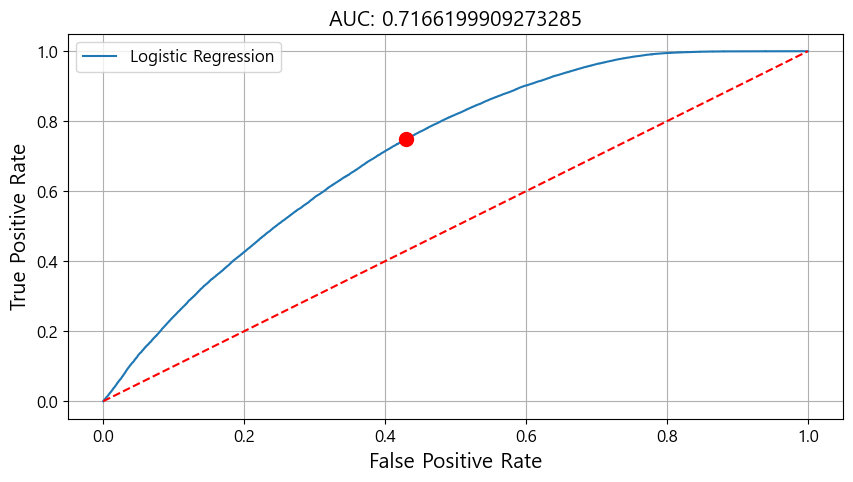

Precision-Recall Curve: Train


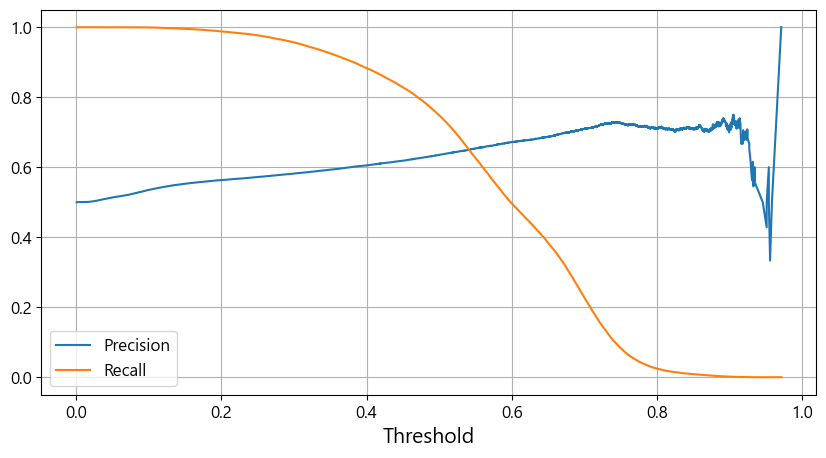

In [46]:
# Logistic Regression
X_train_fes = sm.add_constant(X_train_encoded, has_constant='add')
X_test_fes = sm.add_constant(X_test_encoded)

model_logitreg = LogisticRegression(fit_intercept=False)
model_logitreg.fit(X_train_fes, y)

## 계수 해석
print("Effect of X..")
display(pd.DataFrame({'features': X_train_fes.columns,
                      'coef': model_logitreg.coef_[0],
                      'odds': np.exp(model_logitreg.coef_[0])}))

# 예측
Y_trpred = model_logitreg.predict(X_train_fes)
P_trpred = model_logitreg.predict_proba(X_train_fes)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
display(evaluation_class_ConfusionMatrix(y, Y_trpred))

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(y, Y_trpred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(y, P_trpred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(y, P_trpred[:,1])

변수 중요도: 


,Importance
시술 당시 나이,0.02
임신 시도 또는 마지막 임신 경과 연수,0.01
특정 시술 유형,0.02
배란 유도 유형,0.00
단일 배아 이식 여부,0.02
...,...
배아_이식_비율,0.09
난자_수정_성공률,0.08
이전_IVF_임신률,0.02
기증_여부,0.01


Confusion Matrix: Train


,Pred: 0,Pred: 1
True: 0,63747,2481
True: 1,2108,64120


Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.97      0.96      0.97     66228
     class 1       0.96      0.97      0.97     66228

    accuracy                           0.97    132456
   macro avg       0.97      0.97      0.97    132456
weighted avg       0.97      0.97      0.97    132456

ROC Curve: Train


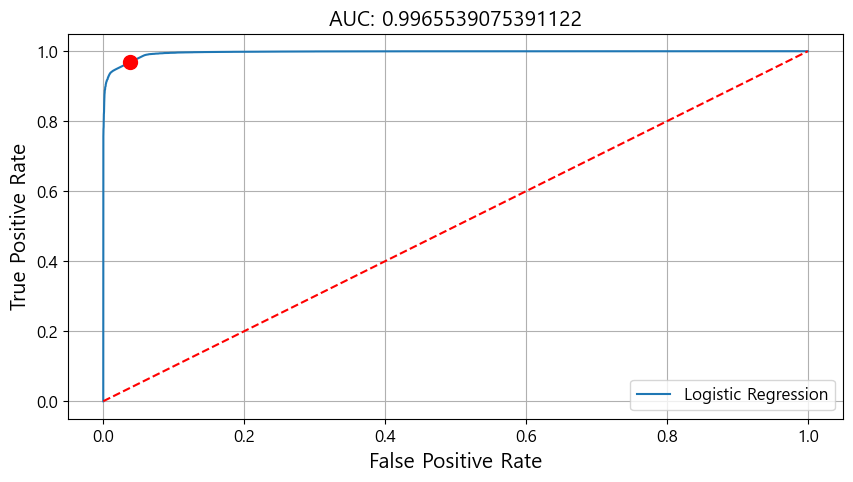

Precision-Recall Curve: Train


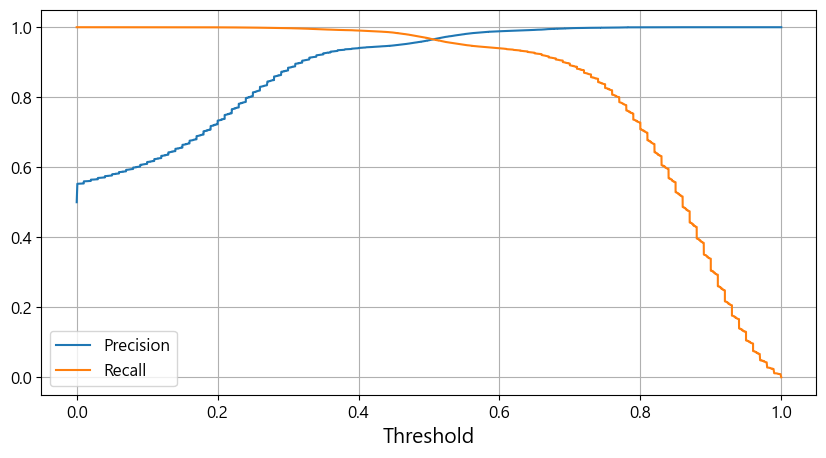

In [47]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=123)
model_rf.fit(X_train_encoded, y)
print("변수 중요도: ")
display(pd.DataFrame(model_rf.feature_importances_, 
                     index=model_rf.feature_names_in_, columns=['Importance']))

# 예측
Y_trpred = model_rf.predict(X_train_encoded)
P_trpred = model_rf.predict_proba(X_train_encoded)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
display(evaluation_class_ConfusionMatrix(y, Y_trpred))

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(y, Y_trpred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(y, P_trpred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(y, P_trpred[:,1])

변수 중요도: 


,Importance
시술 당시 나이,0.02
임신 시도 또는 마지막 임신 경과 연수,0.01
특정 시술 유형,0.02
배란 유도 유형,0.01
단일 배아 이식 여부,0.02
...,...
배아_이식_비율,0.06
난자_수정_성공률,0.08
이전_IVF_임신률,0.02
기증_여부,0.01


Confusion Matrix: Train


,Pred: 0,Pred: 1
True: 0,65519,709
True: 1,3878,62350


Classification Metrics: Train
              precision    recall  f1-score   support

     class 0       0.94      0.99      0.97     66228
     class 1       0.99      0.94      0.96     66228

    accuracy                           0.97    132456
   macro avg       0.97      0.97      0.97    132456
weighted avg       0.97      0.97      0.97    132456

ROC Curve: Train


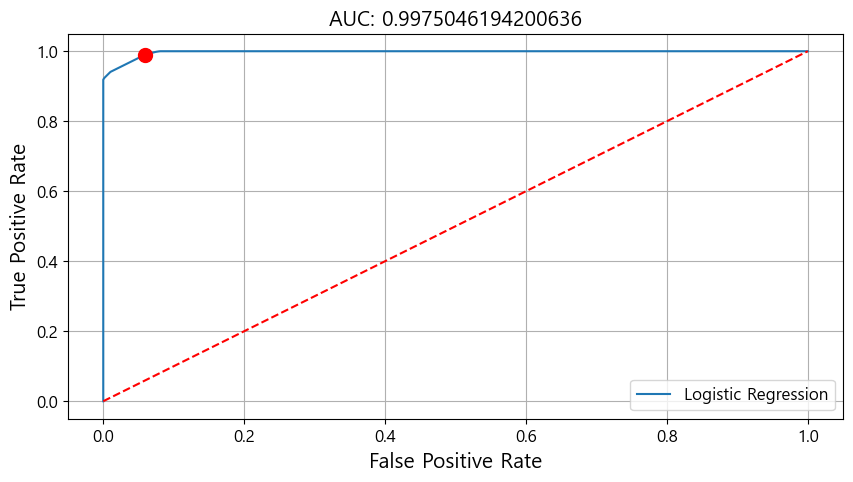

Precision-Recall Curve: Train


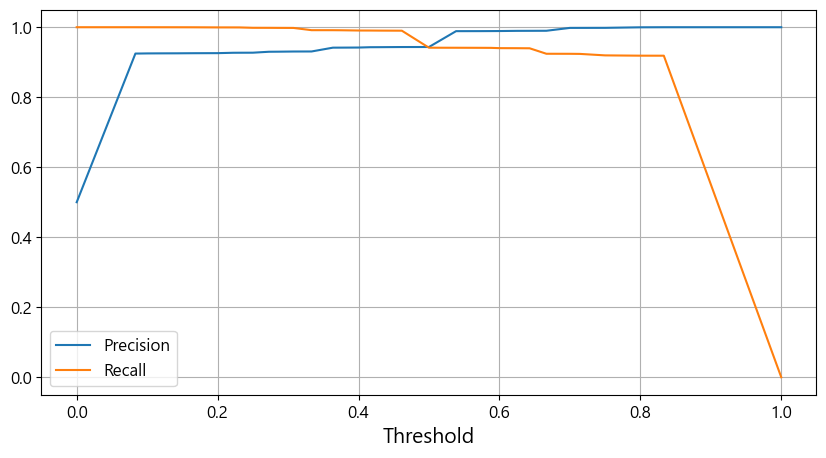

In [48]:
# ExtraTrees
model_et = ExtraTreesClassifier(random_state=42)
model_et.fit(X_train_encoded, y)

print("변수 중요도: ")
display(pd.DataFrame(model_et.feature_importances_, 
                     index=model_et.feature_names_in_, columns=['Importance']))

# 예측
Y_trpred = model_et.predict(X_train_encoded)
P_trpred = model_et.predict_proba(X_train_encoded)

# 평가/검증
## Confusion Matrix
print('Confusion Matrix: Train')
display(evaluation_class_ConfusionMatrix(y, Y_trpred))

## Classification Metrics
print('Classification Metrics: Train')
evaluation_class_ClassificationReport(y, Y_trpred)

## ROC Curve + AUC
print('ROC Curve: Train')
evaluation_class_ROCAUC(y, P_trpred[:,1])

## Precision-Recall Curve
print('Precision-Recall Curve: Train')
evaluation_class_PrecisionRecall(y, P_trpred[:,1])

## 최종

- Train data 예측 성능만 확인 가능

In [49]:
# XGBoost
model_xgb = XGBClassifier(n_estimators=100,
                          learning_rate=0.1,
                          max_depth=3, random_state=123,
                          eval_metric='mlogloss')

# LightGBM
model_lgbm = LGBMClassifier(n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3, random_state=123)

# CatBoost
model_cb = CatBoostClassifier(n_estimators=100,
                              learning_rate=0.1,
                              max_depth=3, random_state=123,
                              verbose=0)

In [50]:
X_train_fes = X_train_encoded
X_test_fes = X_test_encoded
Y_train = y

In [52]:
# 모델 정의 
models = {
    'Logistic Regression': model_logitreg,
    'Random Forest': model_rf,
    'XGBoost': model_xgb,
    'LightGBM': model_lgbm,
    'CatBoost': model_cb}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    print(f'------{name}------')
    
    model.fit(X_train_fes, Y_train)
    y_pred = model.predict(X_train_fes)
    
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_train_fes)[:, 1]
    else:
        y_pred_proba = model.decision_function(X_train_fes)

    # 평가 지표
    accuracy = accuracy_score(Y_train, y_pred)
    precision = precision_score(Y_train, y_pred)
    recall = recall_score(Y_train, y_pred)
    f1 = f1_score(Y_train, y_pred)


    cm = confusion_matrix(Y_train, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    fpr, tpr, thresholds = roc_curve(Y_train, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 결과 저장
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1,
        'Accuracy': accuracy,
        'AUC': roc_auc
    })

results_df = pd.DataFrame(results)

print('X_Train shape:', X_train_fes.shape, 'Y_train_shape:', Y_train.shape)
# print('X_Test shape:', X_test_fes.shape, 'Y_test_shape:', Y_test.shape)

# Set pandas display option for decimal places
pd.set_option('display.float_format', '{:.5f}'.format)
display(results_df)


------Logistic Regression------
------Random Forest------
------XGBoost------
------LightGBM------
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 66228, number of negative: 66228
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 132456, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warnin

X_Train shape: (132456, 35) Y_train_shape: (132456,)


,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,Logistic Regression,0.63491,0.74837,0.56967,0.68699,0.65902,0.71649
1,Random Forest,0.96275,0.96817,0.96254,0.96545,0.96535,0.99655
2,XGBoost,0.63996,0.78938,0.55590,0.70686,0.67264,0.73818
3,LightGBM,0.64033,0.78816,0.55730,0.70660,0.67273,0.73800
4,CatBoost,0.63855,0.78739,0.55430,0.70520,0.67084,0.73582


# Predict

In [54]:
# 랜덤 포레스트로 예측

pred_proba = model_rf.predict_proba(X_test_encoded)[:, 1]
pred_proba

array([0.        , 0.        , 0.37      , ..., 0.53666667, 0.37      ,
       0.        ])

# Submission

In [55]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['probability'] = pred_proba

In [56]:
sample_submission.to_csv('./submit8.csv', index=False)